In [26]:
!pip install keras_cv
!pip install tensorflow
!pip install pycocotools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv
import requests
import zipfile

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


# Getting Data

## Dataset and Training Parameters

In [ ]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCH = 1
GLOBAL_CLIPNORM = 10.0

## Dataset Preparation

In [7]:
class_ids = ["Waldo"]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "/content/drive/MyDrive/waldo_data/data/images"
path_annot = "/content/drive/MyDrive/waldo_data/data/Annotations"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

**Next is parsing the XML annotation files to store the labels and bounding box annotations needed for training.**

In [8]:
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/47 [00:00<?, ?it/s]

In [9]:
type(bbox)

list

In [10]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [11]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [12]:
val_data.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 RaggedTensorSpec(TensorShape([None]), tf.int32, 0, tf.int64),
 RaggedTensorSpec(TensorShape([None, None]), tf.float32, 1, tf.int64))

In [13]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(1.0, 1.0),
            bounding_box_format="xyxy",
        ),
    ]
)

train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(1.0, 1.0),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
val_ds.element_spec

{'images': TensorSpec(shape=(8, 640, 640, 3), dtype=tf.float32, name=None),
 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([8, None]), tf.float32, 1, tf.int64),
  'boxes': RaggedTensorSpec(TensorShape([8, None, None]), tf.float32, 1, tf.int64)}}

In [19]:
# Check the first few elements in val_ds
# for element in val_ds.take(5):
#     print(element)

In [17]:
# # Check the first few elements in train_ds
# for element in train_ds.take(1):
#     print(element)

In [18]:
train_ds

<_ParallelMapDataset element_spec={'images': TensorSpec(shape=(8, 640, 640, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([8, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([8, None, None]), tf.float32, 1, tf.int64)}}>

In [20]:
val_ds.element_spec

{'images': TensorSpec(shape=(8, 640, 640, 3), dtype=tf.float32, name=None),
 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([8, None]), tf.float32, 1, tf.int64),
  'boxes': RaggedTensorSpec(TensorShape([8, None, None]), tf.float32, 1, tf.int64)}}

In [21]:
# Check the number of elements in the datasets
print("Number of elements in train_ds:", len(list(train_ds)))
print("Number of elements in val_ds:", len(list(val_ds)))

Number of elements in train_ds: 4
Number of elements in val_ds: 1


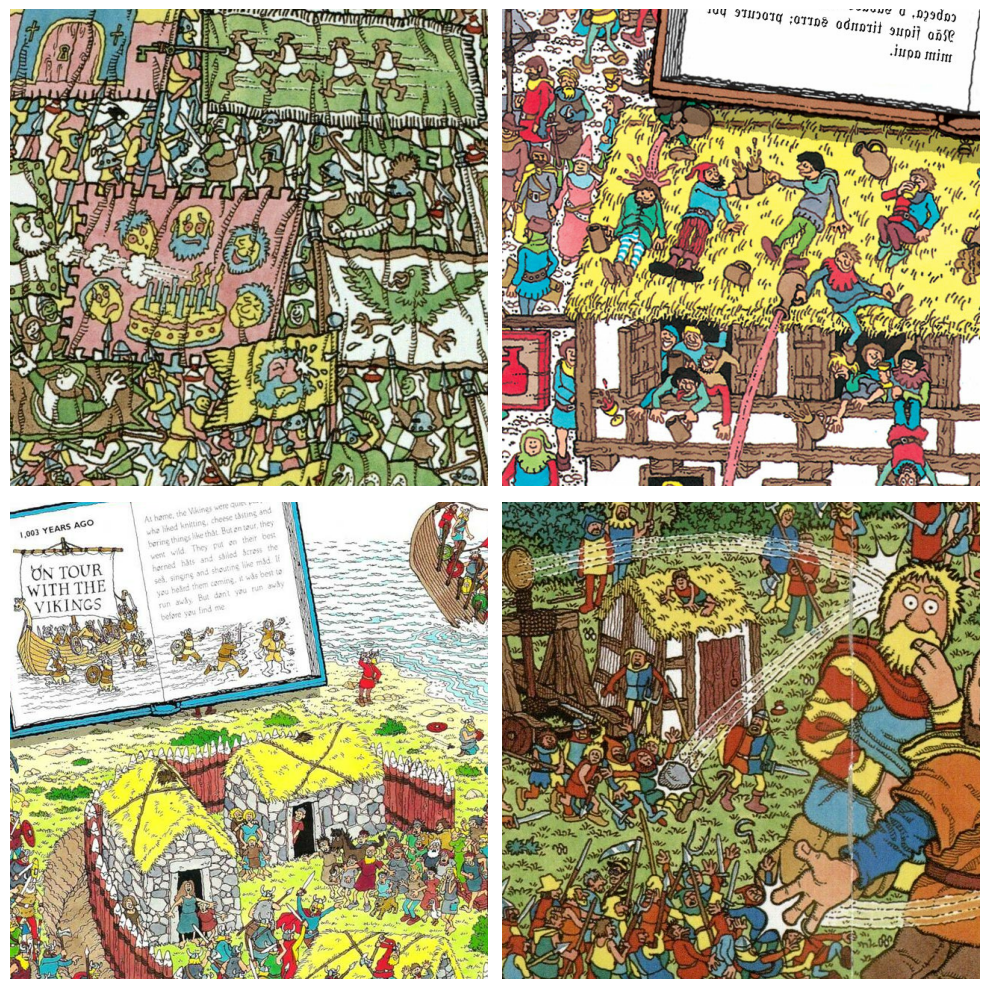

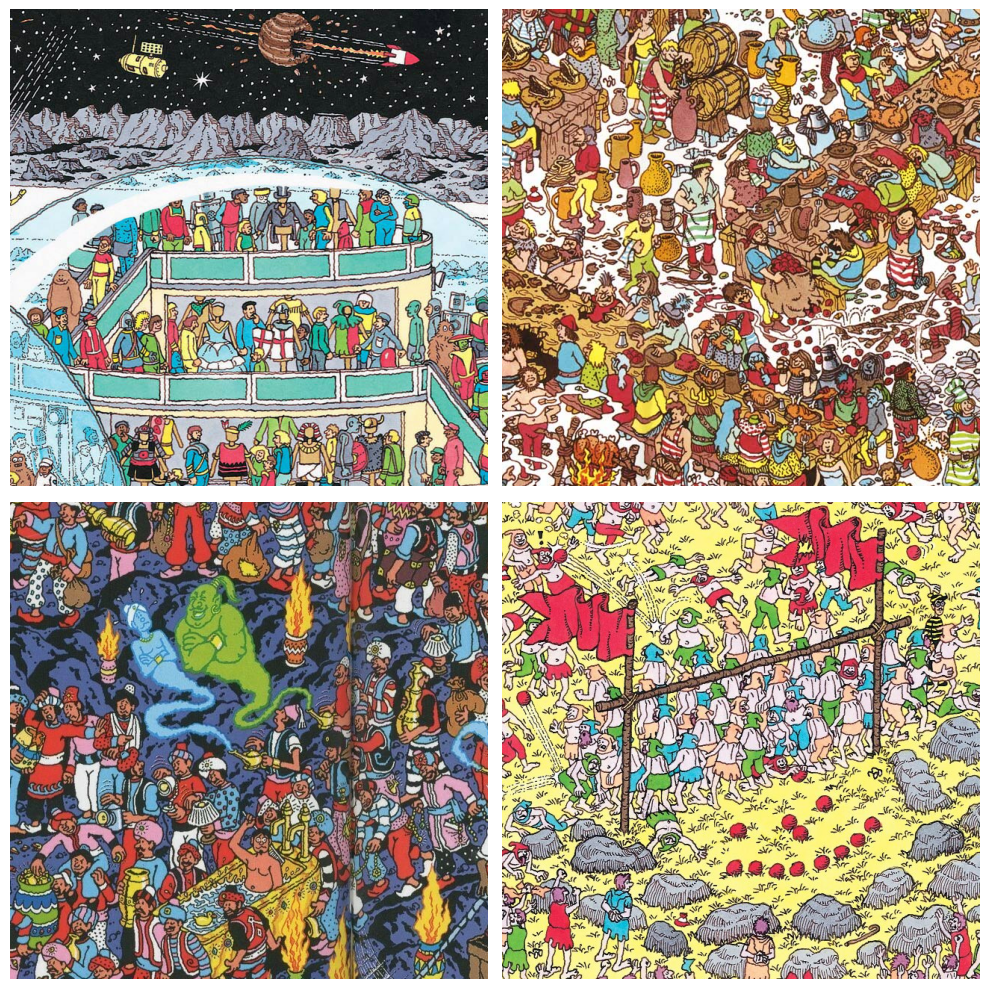

In [22]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    # inputs = inputs.take(1)
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [34]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__dict_to_tuple() takes 1 positional argument but 2 were given


In [50]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone_coco",
    load_weights=True
)

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3,
)

yolo.summary()

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model: "yolov8_detector_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_5 (Functional)        {'P3': (None, None, None,    1983174   ['input_12[0][0]']            
                             256),                        4                                       
                              'P4': (None, None, None,                                            
                             512),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                

In [43]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [44]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path + '.keras')  # Save the model when mAP improves

        return logs

In [45]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs_yolov8large")

In [46]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_MaP',
    mode='max'
)

callbacks=[
    EvaluateCOCOMetricsCallback(val_ds, "model_yolov8large.h5"),
    tensorboard_callback,
    early_stopping
]

In [47]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=callbacks
)

4/4 [==============================] - ETA: 0s - loss: 18916.6289 - box_loss: 4.0292 - class_loss: 18912.5996

4/4 [==============================] - 101s 8s/step - loss: 18916.6289 - box_loss: 4.0292 - class_loss: 18912.5996 - val_loss: 492413.1562 - val_box_loss: 0.0000e+00 - val_class_loss: 492413.1562 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


In [49]:
history.history

{'loss': [18916.62890625],
 'box_loss': [4.029173374176025],
 'class_loss': [18912.599609375],
 'val_loss': [492413.15625],
 'val_box_loss': [0.0],
 'val_class_loss': [492413.15625],
 'MaP': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'MaP@[IoU=50]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'MaP@[IoU=75]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'MaP@[area=small]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'MaP@[area=medium]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'MaP@[area=large]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'Recall@[max_detections=1]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'Recall@[max_detections=10]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'Recall@[max_detections=100]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'Recall@[area=small]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'Recall@[area=medium]': [<tf.Tensor: shape=(), dtype=float32, numpy=0.0>],
 'Recall